<a href="https://colab.research.google.com/github/harol911/UPSRJ_PYTORCH_WORKSPACE/blob/main/FaceRecognition_JetBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconocimiento Facial con FaceNet — Preparación para JetBot (ROS Melodic)

Este cuaderno te guiará paso a paso para:

1. **Entrenar un modelo** de reconocimiento facial usando *FaceNet* (para obtener "embeddings" faciales).
2. **Entrenar un clasificador SVM** para distinguir rostros.
3. **Guardar el modelo** en formatos portables (`.pkl` y `.onnx`) que se ejecutarán después en tu JetBot Nano con Python 2.7.

---

## 1. Configuración del entorno

Asegúrate de tener la GPU activada:  
> Menú → Entorno de ejecución → Cambiar tipo de entorno → Hardware acelerador → GPU

In [1]:
!pip install facenet-pytorch torch torchvision scikit-learn opencv-python matplotlib joblib onnx


## 2. Importación de librerías

In [2]:
import torch
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN, InceptionResnetV1
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import joblib

## 3. Carga de imágenes de entrenamiento

Para este ejemplo, crearemos una pequeña base de datos:
- Cada subcarpeta dentro de `data/` contendrá imágenes de una persona.

Puedes subir tus propias imágenes (por ejemplo, de tus compañeros) o usar imágenes descargadas de Internet.


In [3]:
from google.colab import files
!mkdir -p data
print("Crea una carpeta data/persona1, data/persona2, etc. y sube tus fotos")

uploaded = files.upload()
for name, file in uploaded.items():
    with open(os.path.join("data", name), "wb") as f:
        f.write(file)
print("Archivos cargados.")


Crea una carpeta data/persona1, data/persona2, etc. y sube tus fotos


Saving fotos do rwijer.jpg to fotos do rwijer.jpg
Saving HEAD-face-recognition-696x696.jpg to HEAD-face-recognition-696x696.jpg
Saving ssssss.jpg to ssssss.jpg
Saving sssssssssssssssssssssss.jpg to sssssssssssssssssssssss.jpg
Saving WhatsApp Image 2025-10-30 at 17.48.08 (2).jpeg to WhatsApp Image 2025-10-30 at 17.48.08 (2).jpeg
Saving WhatsApp Image 2025-10-30 at 17.48.09 (1).jpeg to WhatsApp Image 2025-10-30 at 17.48.09 (1).jpeg
Saving WhatsApp Image 2025-10-30 at 17.48.09 (2).jpeg to WhatsApp Image 2025-10-30 at 17.48.09 (2).jpeg
Saving WhatsApp Image 2025-10-30 at 17.48.09 (3).jpeg to WhatsApp Image 2025-10-30 at 17.48.09 (3).jpeg
Saving WhatsApp Image 2025-10-30 at 17.48.09.jpeg to WhatsApp Image 2025-10-30 at 17.48.09.jpeg
Archivos cargados.


## 4. Extracción de rostros y embeddings
Usaremos **MTCNN** para detectar rostros y **FaceNet (InceptionResnetV1)** para convertirlos en vectores numéricos (*embeddings*).


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(image_size=160, margin=20, device=device)
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

X, y = [], []

for person in os.listdir("data"):
    person_path = os.path.join("data", person)
    if not os.path.isdir(person_path):
        continue

    for file in os.listdir(person_path):
        path = os.path.join(person_path, file)
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        face = mtcnn(img)
        if face is not None:
            emb = resnet(face.unsqueeze(0).to(device)).detach().cpu().numpy()
            X.append(emb.flatten())
            y.append(person)

print("Rostros procesados:", len(X))


  0%|          | 0.00/107M [00:00<?, ?B/s]

Rostros procesados: 9


## 5. Entrenamiento del clasificador SVM

El clasificador SVM aprenderá a diferenciar las personas según los *embeddings* de sus rostros.


In [5]:
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)

model = SVC(kernel='linear', probability=True)
model.fit(X, y_enc)

print("Clasificador entrenado con", len(set(y_enc)), "personas.")


Clasificador entrenado con 2 personas.


## 6. Prueba rápida de predicción
Sube una foto de prueba y verifica qué persona detecta.


Saving WhatsApp Image 2025-10-30 at 17.48.09 (1).jpeg to WhatsApp Image 2025-10-30 at 17.48.09 (1) (1).jpeg


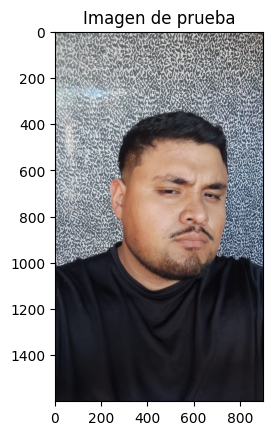

Predicción: harol


In [6]:
from google.colab import files
uploaded = files.upload()
test_img_path = list(uploaded.keys())[0]

img = cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title("Imagen de prueba")
plt.show()

face = mtcnn(img)
if face is not None:
    emb = resnet(face.unsqueeze(0).to(device)).detach().cpu().numpy()
    pred = model.predict(emb)
    name = encoder.inverse_transform(pred)[0]
    print("Predicción:", name)
else:
    print("No se detectó ningún rostro.")


## 7. Guardar los modelos para la Jetson Nano
Guardaremos:
- El clasificador y el codificador (`.pkl`)
- El modelo FaceNet en formato **ONNX** (para poder usarlo desde Python 2.7 con `onnxruntime`)


In [7]:
joblib.dump(model, 'face_svm.pkl')
joblib.dump(encoder, 'label_encoder.pkl')

# Exportar FaceNet a ONNX
dummy = torch.randn(1, 3, 160, 160).to(device)
torch.onnx.export(resnet, dummy, "facenet.onnx", opset_version=11)
print("Archivos guardados: face_svm.pkl, label_encoder.pkl, facenet.onnx")


Archivos guardados: face_svm.pkl, label_encoder.pkl, facenet.onnx


## 8. Descargar modelos entrenados



In [8]:
from google.colab import files
files.download('face_svm.pkl')
files.download('label_encoder.pkl')
files.download('facenet.onnx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 9. Qué hacer después

1. **Copia los archivos al JetBot Nano (Python 2.7):**
   ```bash
   scp face_svm.pkl label_encoder.pkl facenet.onnx jetbot@<IP_JETBOT>:/home/jetbot/models/
   ```
2. **En la Jetson**, usa el script ROS 1 (Python 2.7) para ejecutar la inferencia facial:
- Lee las imágenes de la cámara.
- Carga `facenet.onnx` con onnxruntime.
- Clasifica con `face_svm.pkl`.
- Publica el nombre en `/face_recognition/name`.

3. **Desde otro nodo ROS**, controla el movimiento según el rostro reconocido.

## Reflexión

- En Colab usamos *Python 3 y GPU* → ideal para entrenamiento.
- En JetBot usamos *Python 2.7 y CPU/GPU embebida* → ideal para inferencia.